In [1]:
import tensorflow as tf

C:\Users\aakas\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\aakas\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\aakas\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\aakas\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2 as cv
import imutils
import numpy as np
from matplotlib import pyplot as plt
import time
from os import listdir

%matplotlib inline

In [3]:
def crop_brain_contour(image, plot=False):
  
  gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray,(5,5),0)
    
  thresh = cv.threshold(gray,45,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
  thresh = cv.erode(thresh, None, iterations=2)
  thresh = cv.dilate(thresh,None,iterations=2)

  cnts = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv.contourArea)

  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0]) 
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])

  new_image = image[extTop[1]:extBot[1],extLeft[0]:extRight[0]]

  if plot:
    plt.figure()

    plt.subplot(1,2,1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Original image')
    plt.subplot(1,2,2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('Cropped Image')
    plt.show()

  return new_image

In [4]:
def load_data(dir_list,image_size):
  x=[]
  y=[]

  image_width,image_height = image_size
  for directory in dir_list:
    for filename in listdir(directory):

      #print(directory)
      #print(filename)
      image = cv.imread(directory + '/' + filename)
      #print(image)
      image = crop_brain_contour(image,plot=False)
      image = cv.resize(image,dsize=(image_width,image_height),interpolation = cv.INTER_CUBIC)

      image=image/255
      x.append(image)

      if directory[-3:] == 'yes':
        y.append([1])
      else:
        y.append([0]) 

  X = np.array(x)
  y = np.array(y)

  X,y = shuffle(X,y)

  print(f'Number of examples: {len(X)}')
  print(f'X shape:{X.shape}')
  print(f'Y shape:{y.shape}')

  return X,y

In [5]:
path = 'augmented/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = path + 'yes' 
augmented_no = path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of examples: 2155
X shape:(2155, 240, 240, 3)
Y shape:(2155, 1)


In [6]:
def split_data(X, y, test_size=0.2):
  X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
  X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

  return X_train,y_train,X_val,y_val,X_test,y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [8]:
def build_model(image_shape):
  X_input = Input(image_shape)
  #print(X_input)
  X = ZeroPadding2D((2,2))(X_input)

  X = Conv2D(32, (7,7), strides=(1,1), name='conv0')(X)
  X = BatchNormalization(axis=3,name='bn0')(X)
  X = Activation('relu')(X)

  X = MaxPooling2D((4,4),name='max_pool0')(X)

  X = MaxPooling2D((4,4),name='max_pool1')(X)

  X = Flatten()(X)

  X = Dense(1,activation='sigmoid',name='fc')(X)

  model = Model(inputs=X_input,outputs=X,name='TumorDetection')
  return model

In [9]:
IMG_SHAPE = IMG_WIDTH,IMG_HEIGHT,3

In [10]:
model = build_model(IMG_SHAPE)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=25,validation_data=(X_val,y_val))

Train on 1508 samples, validate on 324 samples
Epoch 1/25
1508/1508 [==============================] - 247s 164ms/sample - loss: 0.8131 - acc: 0.6154 - val_loss: 0.6509 - val_acc: 0.6049
Epoch 2/25
1508/1508 [==============================] - 218s 145ms/sample - loss: 0.5523 - acc: 0.7294 - val_loss: 0.6006 - val_acc: 0.6574
Epoch 3/25
1508/1508 [==============================] - 218s 144ms/sample - loss: 0.4925 - acc: 0.7745 - val_loss: 0.5931 - val_acc: 0.7160
Epoch 4/25
1508/1508 [==============================] - 213s 141ms/sample - loss: 0.4912 - acc: 0.7593 - val_loss: 0.5811 - val_acc: 0.7099
Epoch 5/25
1508/1508 [==============================] - 210s 139ms/sample - loss: 0.4626 - acc: 0.7725 - val_loss: 0.6696 - val_acc: 0.5988
Epoch 6/25
1508/1508 [==============================] - 662s 439ms/sample - loss: 0.4440 - acc: 0.7991 - val_loss: 0.6074 - val_acc: 0.7099
Epoch 7/25
1508/1508 [==============================] - 202s 134ms/sample - loss: 0.4000 - acc: 0.8223 - val_loss

In [13]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=2,validation_data=(X_val,y_val))

Train on 1508 samples, validate on 324 samples
Epoch 1/2
1508/1508 [==============================] - 204s 135ms/sample - loss: 0.1607 - acc: 0.9430 - val_loss: 0.5275 - val_acc: 0.7963
Epoch 2/2
1508/1508 [==============================] - 207s 137ms/sample - loss: 0.1469 - acc: 0.9595 - val_loss: 0.6023 - val_acc: 0.7778


In [14]:
model.fit(x=X_train,y=y_train,batch_size=32,epochs=20,validation_data=(X_val,y_val))

Train on 1508 samples, validate on 324 samples
Epoch 1/20
1508/1508 [==============================] - 206s 137ms/sample - loss: 0.1402 - acc: 0.9602 - val_loss: 0.8358 - val_acc: 0.7006
Epoch 2/20
1508/1508 [==============================] - 207s 137ms/sample - loss: 0.1675 - acc: 0.9357 - val_loss: 0.6035 - val_acc: 0.7870
Epoch 3/20
1508/1508 [==============================] - 205s 136ms/sample - loss: 0.1688 - acc: 0.9456 - val_loss: 0.7966 - val_acc: 0.7716
Epoch 4/20
1508/1508 [==============================] - 203s 135ms/sample - loss: 0.1657 - acc: 0.9324 - val_loss: 0.6527 - val_acc: 0.7654
Epoch 5/20
1508/1508 [==============================] - 201s 133ms/sample - loss: 0.1625 - acc: 0.9363 - val_loss: 0.6175 - val_acc: 0.7932
Epoch 6/20
1508/1508 [==============================] - 216s 143ms/sample - loss: 0.1184 - acc: 0.9662 - val_loss: 0.5742 - val_acc: 0.8241
Epoch 7/20
1508/1508 [==============================] - 241s 160ms/sample - loss: 0.1075 - acc: 0.9775 - val_loss

In [15]:
history = model.history.history


In [16]:
for key in history.keys():
  print(key)

loss
acc
val_loss
val_acc


In [17]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['acc']
    val_acc = history['val_acc']
    
    trainAcc=0
    
    for ele in range(0, len(train_acc)): 
        trainAcc = trainAcc + train_acc[ele]
    
    print('Training Accuracy - ',trainAcc/len(train_acc))
    
    valAcc=0
    
    for ele in range(0, len(val_acc)): 
        valAcc = valAcc + val_acc[ele]
    
    print('Validation Accuracy - ',valAcc/len(val_acc))
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

Training Accuracy -  0.9669098198413849
Validation Accuracy -  0.7862654328346252


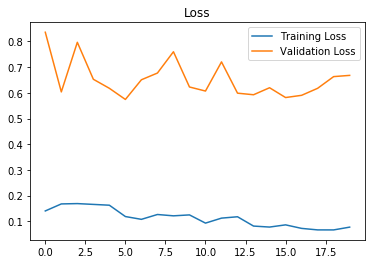

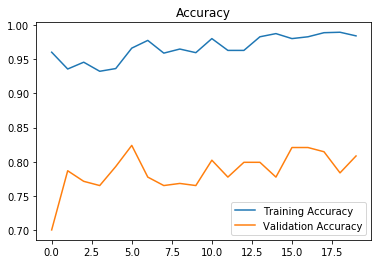

In [18]:
plot_metrics(history)

In [28]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('prediction/yes_or_no_2.jpg', target_size = (240, 240))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
#training_set.class_indices
if result[0][0] == 1:
  prediction = 'tumor detected'
else:
  prediction = 'no tumor detected'

In [29]:
print(prediction)

no tumor detected
